# Интерактивное обновление параметров и пересчёт топ-кадров
Данный блок позволяет выбрать новые координаты обрезки и веса метрик, сохранить их в конфиг и обновить результаты.

In [28]:
# 2-param-selection.ipynb
import os
import json
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Image as IPImage
from PIL import Image

def load_config():
    """Загрузка или создание конфигурации"""
    if os.path.exists(config_path):
        with open(config_path, 'r') as f:
            return json.load(f)
    return {
        "weights": {
            "WEIGHT_TEXT": 0.1,
            "WEIGHT_DIFF": 0.6,
            "WEIGHT_SIMILARITY": 0.2,
            "WEIGHT_RECENCY": 0.05
        },
        "coordinates": {
            "x1": 0, "y1": 0,
            "x2": 1920, "y2": 1080
        }
    }

def show_top_frames():
    """Показать топ-3 кадра с сеткой"""
    top_files = sorted([f for f in os.listdir(top_frames_dir) if f.endswith('.jpg')])[:3]
    
    if not top_files:
        print("Нет топ-кадров для отображения")
        return

    fig, axes = plt.subplots(1, len(top_files), figsize=(15,5))
    for ax, file in zip(axes, top_files):
        img = cv2.cvtColor(cv2.imread(os.path.join(top_frames_dir, file)), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(file)
        h, w = img.shape[:2]
        # Рисуем сетку
        for x in range(0, w, 100):
            ax.axvline(x, color='white', linestyle='--', alpha=0.5)
        for y in range(0, h, 100):
            ax.axhline(y, color='white', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def show_metrics_plot():
    """Показать сохраненную диаграмму метрик"""
    if os.path.exists(metrics_plot_path):
        img = plt.imread(metrics_plot_path)
        plt.figure(figsize=(15,5))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Текущее распределение метрик")
        plt.show()
    else:
        print("Диаграмма метрик не найдена!")

def update_parameters(config):
    """Интерактивное обновление параметров"""
    print("\n=== Настройка параметров обрезки ===")
    coords = config['coordinates']
    coords['x1'] = int(input(f"x1 (current: {coords['x1']}): ") or coords['x1'])
    coords['y1'] = int(input(f"y1 (current: {coords['y1']}): ") or coords['y1'])
    coords['x2'] = int(input(f"x2 (current: {coords['x2']}): ") or coords['x2'])
    coords['y2'] = int(input(f"y2 (current: {coords['y2']}): ") or coords['y2'])

    print("\n=== Настройка весов метрик ===")
    weights = config['weights']
    weights['WEIGHT_TEXT'] = float(input(f"WEIGHT_TEXT (current: {weights['WEIGHT_TEXT']}): ") or weights['WEIGHT_TEXT'])
    weights['WEIGHT_DIFF'] = float(input(f"WEIGHT_DIFF (current: {weights['WEIGHT_DIFF']}): ") or weights['WEIGHT_DIFF'])
    weights['WEIGHT_SIMILARITY'] = float(input(f"WEIGHT_SIMILARITY (current: {weights['WEIGHT_SIMILARITY']}): ") or weights['WEIGHT_SIMILARITY'])
    weights['WEIGHT_RECENCY'] = float(input(f"WEIGHT_RECENCY (current: {weights['WEIGHT_RECENCY']}): ") or weights['WEIGHT_RECENCY'])

    # Сохранение конфига
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)
    return config

def frame_diff(frame1, frame2):
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    return np.sum(cv2.absdiff(gray1, gray2)) / gray1.size


def recalculate_metrics(config):
    """Пересчет метрик с новыми параметрами"""
    with open(all_frames_data, 'r') as f:
        frames = json.load(f)

    # Обновление diff scores
    x1, y1, x2, y2 = config['coordinates'].values()
    prev_crop = None
    
    for frame in frames:
        img_path = os.path.join(all_frames_dir, frame['filename'])
        img = cv2.imread(img_path)
        if img is not None:
            crop = img[y1:y2, x1:x2]
            if prev_crop is not None:  # Явная проверка на None
                frame['diff_score'] = frame_diff(crop, prev_crop)
            else:
                frame['diff_score'] = 0  # Для первого кадра
            prev_crop = crop

    # Нормализация
    scaler = MinMaxScaler()
    for metric in ['text_quantity', 'diff_score', 'sim_score']:
        values = np.array([f[metric] for f in frames]).reshape(-1, 1)
        normalized = scaler.fit_transform(values).flatten()
        for i, f in enumerate(frames):
            f[f'{metric}_norm'] = float(normalized[i])  # Явное преобразование в float

    return frames

def plot_updated_metrics(frames, config):
    """Построение обновленной диаграммы"""
    plt.figure(figsize=(15,7))
    
    times = [f['timecode'] for f in frames]
    bar_width = 8  # Ширина столбца в секундах
    
    # Вычисляем компоненты
    components = {
        'text': np.array([f['text_quantity_norm'] * config['weights']['WEIGHT_TEXT'] for f in frames]),
        'diff': np.array([f['diff_score_norm'] * config['weights']['WEIGHT_DIFF'] for f in frames]),
        'sim': np.array([f['sim_score_norm'] * config['weights']['WEIGHT_SIMILARITY'] for f in frames]),
        'recency': np.array([f.get('recency_norm', 0) * config['weights']['WEIGHT_RECENCY'] for f in frames])
    }
    
    bottom = np.zeros(len(times))
    for name, values in components.items():
        plt.bar(times, values, width=bar_width, bottom=bottom, label=name.capitalize())
        bottom += values

    plt.title("Обновленные составные метрики")
    plt.xlabel("Время (с)")
    plt.ylabel("Совокупная оценка")
    plt.legend()
    plt.grid(True)
    plt.savefig(metrics_plot_path)
    plt.show()


def remove_directory_contents(directory):
    """Рекурсивное удаление всех файлов и поддиректорий в given directory."""
    if os.path.exists(directory):
        for root, dirs, files in os.walk(directory, topdown=False):
            for name in files:
                try:
                    os.remove(os.path.join(root, name))
                    print(f"Удален файл: {os.path.join(root, name)}")
                except Exception as e:
                    print(f"Ошибка удаления файла {os.path.join(root, name)}: {e}")
            for name in dirs:
                try:
                    os.rmdir(os.path.join(root, name))
                    print(f"Удалена папка: {os.path.join(root, name)}")
                except Exception as e:
                    print(f"Ошибка удаления папки {os.path.join(root, name)}: {e}")
        # Наконец, можно попробовать удалить саму директорию, если нужно:
        # os.rmdir(directory)
    else:
        print(f"Директория {directory} не существует.")

def update_top_frames(frames, config, top_n, top_frames_dir, all_frames_dir):
    """
    Обновляет топ-кадры:
      - Рекурсивно удаляет содержимое директории top_frames_dir.
      - Сортирует кадры по суммарному баллу (на основе нормализованных метрик и весов).
      - Сохраняет топ-N кадров с учетом новых координат обрезки.
      - Обновляет JSON с данными топ-кадров.
    """
    # Удаляем содержимое директории вручную
    remove_directory_contents(top_frames_dir)
    # Если директория не существует, создаем её
    if not os.path.exists(top_frames_dir):
        os.makedirs(top_frames_dir, exist_ok=True)
        print(f"Создана директория: {top_frames_dir}")
    
    # Сортировка по составному баллу (composite_score) с использованием нормализованных метрик
    sorted_frames = sorted(
        frames,
        key=lambda x: sum([
            x['text_quantity_norm'] * config['weights']['WEIGHT_TEXT'],
            x['diff_score_norm'] * config['weights']['WEIGHT_DIFF'],
            x['sim_score_norm'] * config['weights']['WEIGHT_SIMILARITY'],
            x.get('recency_norm', 0) * config['weights']['WEIGHT_RECENCY']
        ]),
        reverse=True
    )[:top_n]
    
    # Сохранение топ-кадров (обновляем изображения с новыми координатами обрезки)
    x1, y1, x2, y2 = config['coordinates'].values()
    top_frames_data = []
    for i, frame in enumerate(sorted_frames):
        img_path = os.path.join(all_frames_dir, frame['filename'])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Не удалось загрузить изображение: {img_path}")
            continue
        crop = img[y1:y2, x1:x2]
        timestamp = int(round(frame['timecode']))
        filename = f"{timestamp}s_top_{i+1}.jpg"
        out_path = os.path.join(top_frames_dir, filename)
        cv2.imwrite(out_path, crop)
        print(f"Сохранен топ-кадр: {out_path}")
        frame_copy = frame.copy()
        frame_copy['filename'] = filename
        top_frames_data.append(frame_copy)
    
    # Сохранение JSON с данными топ-кадров
    json_path = os.path.join(top_frames_dir, "top_frames_data.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(top_frames_data, f, ensure_ascii=False, indent=4)
    print(f"Обновлен JSON с данными топ-кадров: {json_path}")


In [12]:

# ================== КОНФИГУРАЦИЯ ==================
VIDEO_NAME = "WEEK_3_-_LEC_14"  # Заменить на имя обработанного видео
BASE_DIR = "/home/jupyter/datasphere/s3/transcribation-project/test"
TOP_N_DEFAULT = 10
# ===================================================

# Пути к файлам
config_path = f"{BASE_DIR}/{VIDEO_NAME}_config.json"
all_frames_dir = f"{BASE_DIR}/work/all_images/{VIDEO_NAME}"
top_frames_dir = f"{BASE_DIR}/output/images/{VIDEO_NAME}"
all_frames_data = f"{all_frames_dir}/all_frames_data.json"
metrics_plot_path = f"{all_frames_dir}/composite_score_components.png"


Исходная конфигурация:
{
    "weights": {
        "WEIGHT_TEXT": 0.1,
        "WEIGHT_DIFF": 0.6,
        "WEIGHT_SIMILARITY": 0.2,
        "WEIGHT_RECENCY": 0.07
    },
    "coordinates": {
        "x1": 500,
        "y1": 0,
        "x2": 1920,
        "y2": 1080
    }
}

Текущие топ-кадры:


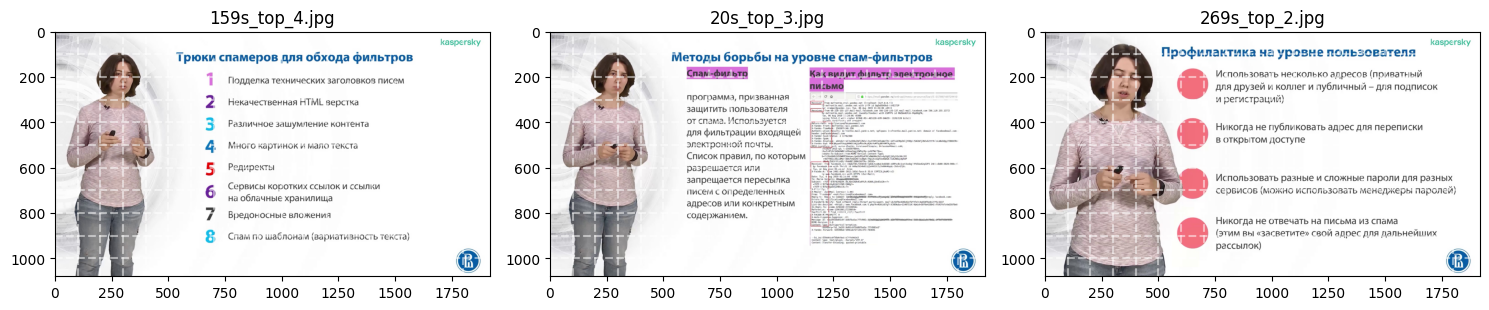


Текущее распределение метрик:


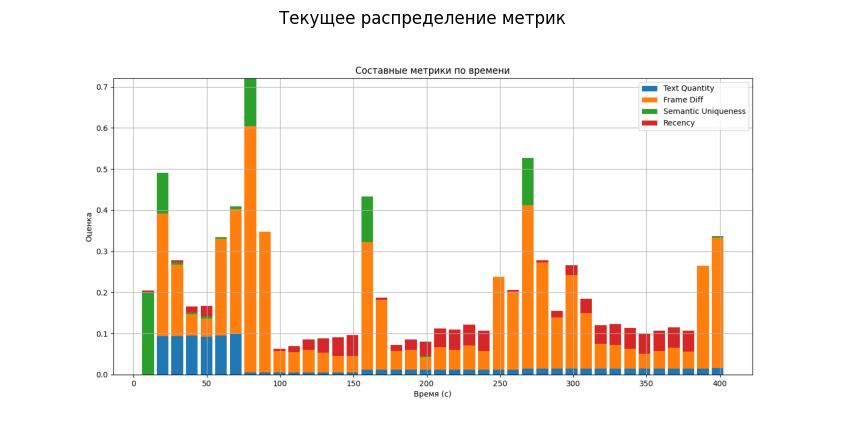

In [13]:

# Инициализация
config = load_config()

# Шаг 1: Показать исходные данные
print("="*50)
print("Исходная конфигурация:")
print(json.dumps(config, indent=4))

print("\nТекущие топ-кадры:")
show_top_frames()

print("\nТекущее распределение метрик:")
show_metrics_plot()




=== Настройка параметров обрезки ===


x1 (current: 500):  500
y1 (current: 0):  0
x2 (current: 1920):  1920
y2 (current: 1080):  1080



=== Настройка весов метрик ===


WEIGHT_TEXT (current: 0.1):  0.1
WEIGHT_DIFF (current: 0.6):  0.6
WEIGHT_SIMILARITY (current: 0.2):  0.2
WEIGHT_RECENCY (current: 0.07):  0.06



Пересчет метрик...

Обновленное распределение метрик:


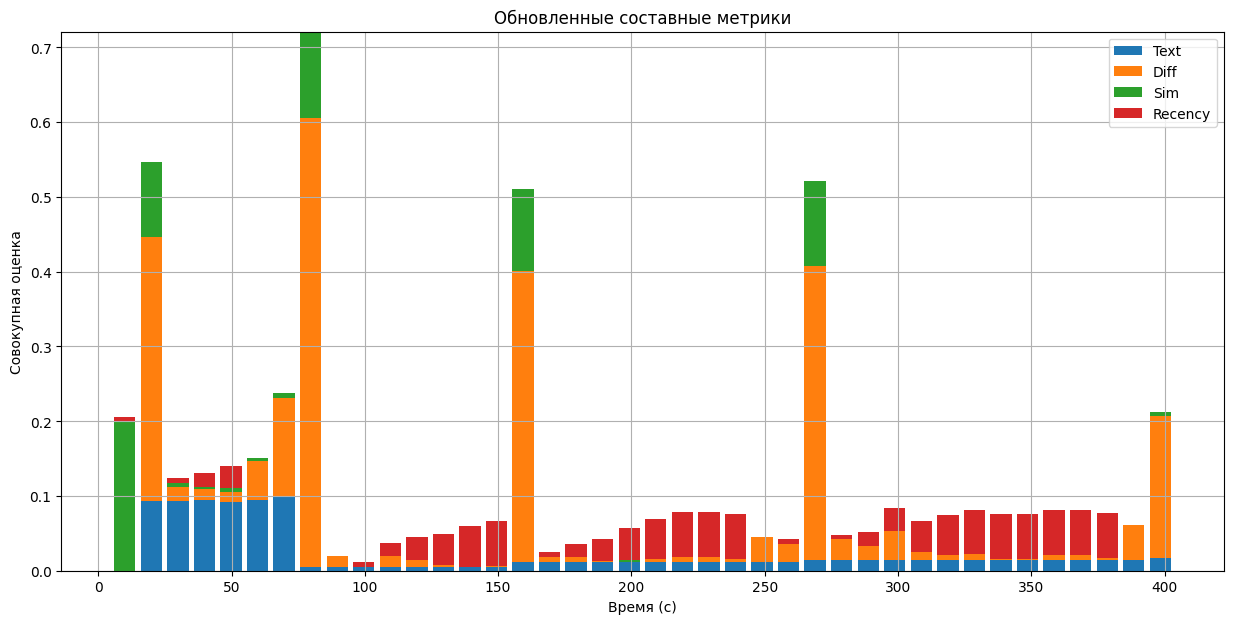

In [14]:
# Шаг 2: Настройка параметров
config = update_parameters(config)

# Шаг 3: Пересчет метрик
print("\nПересчет метрик...")
frames = recalculate_metrics(config)

# Шаг 4: Визуализация новых данных
print("\nОбновленное распределение метрик:")
plot_updated_metrics(frames, config)



In [32]:
# Шаг 5: Обновление топ-кадров
top_n = int(input(f"\nВведите количество топ-кадров (по умолчанию {TOP_N_DEFAULT}): ") or TOP_N_DEFAULT)
update_top_frames(frames, config, top_n, top_frames_dir, all_frames_dir)

# Итог
print("\n" + "="*50)
print("Обновление завершено!")
print(f"Новые топ-{top_n} кадров сохранены в: {top_frames_dir}")
print(f"Новая диаграмма сохранена: {metrics_plot_path}")


Введите количество топ-кадров (по умолчанию 10):  4


Удален файл: /home/jupyter/datasphere/s3/transcribation-project/test/output/images/WEEK_3_-_LEC_14/.ipynb_checkpoints/159s_top_4-checkpoint.jpg
Удален файл: /home/jupyter/datasphere/s3/transcribation-project/test/output/images/WEEK_3_-_LEC_14/.ipynb_checkpoints/20s_top_2-checkpoint.jpg
Удален файл: /home/jupyter/datasphere/s3/transcribation-project/test/output/images/WEEK_3_-_LEC_14/.ipynb_checkpoints/269s_top_3-checkpoint.jpg
Удален файл: /home/jupyter/datasphere/s3/transcribation-project/test/output/images/WEEK_3_-_LEC_14/.ipynb_checkpoints/70s_top_5-checkpoint.jpg
Удален файл: /home/jupyter/datasphere/s3/transcribation-project/test/output/images/WEEK_3_-_LEC_14/.ipynb_checkpoints/80s_top_1-checkpoint.jpg
Удален файл: /home/jupyter/datasphere/s3/transcribation-project/test/output/images/WEEK_3_-_LEC_14/159s_top_4.jpg
Удален файл: /home/jupyter/datasphere/s3/transcribation-project/test/output/images/WEEK_3_-_LEC_14/20s_top_2.jpg
Удален файл: /home/jupyter/datasphere/s3/transcribation-